https://www.kaggle.com/c/GiveMeSomeCredit   -kaggle

I first analyze the predicted confidence and the probability assigned to the true class.

train
→ probabilities
→ confidence anatomy
→ error taxonomy
→ calibration
→ meta-decision
→ cost matrix
→ business loss
→ governance decision

A little story telling as i start my project

Everything I have  built in Misclassification Bonanza 🎰 rests on this.

🟡 Type 1A: Borderline Correct

(Correct label, weak confidence)

What it looks like

y_true == y_pred

predicted_prob ≈ 0.50–0.60

Meaning

Model is unsure

Decision boundary is fuzzy

Signal exists but is weak

Why it happens

Overlapping classes

Poor probability calibration

What to do

✅ Calibration (Platt Signoid s curve or isotonic any monotonic shape  )
❌ No retraining



🟠 Type 1B: Confused Misclassified

(Wrong label, but model sensed truth)

What it looks like

y_true ≠ y_pred

true_class_prob is non-trivial (e.g., ≥ 0.25)

Meaning

Model partially understands

Decision rule failed

Underestimation of risk

Why it happens

Bad threshold

Cost-unaware decision logic

What to do

✅ Threshold tuning ✅ Risk-based routing ❌ No retraining (initially)

🔴 Type 2: Blind Misclassified

(Wrong label, highly confident, ignored truth)

What it looks like

y_true ≠ y_pred

true_class_prob ≈ 0

predicted_prob very high (≥ 0.8)

Meaning

Model didn’t “see” reality

Representation failure

Most dangerous error

Why it happens

Missing / weak features

Class imbalance

Model bias

What to do

✅ Feature engineering ✅ Class-weighted / focal loss ✅ Guardrails ✅ Retraining required

A small misclassification cohort by itself is not a reason to intervene. I will evaluate the type of misclassification and its business impact. If errors are predominantly boundary-level and costs are acceptable, I will  monitor rather than change the system. However, even a small number of blind, high-impact misclassifications warrants targeted intervention despite strong aggregate metrics.

This is why I will  built A cost matrix.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install xgboost

Saving default of credit card clients.xls to default of credit card clients.xls


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    accuracy_score,
    matthews_corrcoef,
    log_loss,
    brier_score_loss,
    confusion_matrix
)

from xgboost import XGBClassifier

In [4]:
df = pd.read_excel("default of credit card clients.xls", header=1)

df = df.rename(columns={"default payment next month": "default"})

X = df.drop(columns=["default"])
y_binary = df["default"]

In [6]:
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
y_binary.value_counts(normalize=True)

,proportion
default,
0,0.7788
1,0.2212


In [8]:
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X,
    y_binary,
    test_size=0.25,
    stratify=y_binary,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

asymmetric risk

FN (missed defaulter) ≫ FP

Class weight injects business reality be it predictive maintaince or credit risk

In [9]:
lr_bin = LogisticRegression(
    max_iter=1000,
    class_weight={0: 1, 1: 5}
)

lr_bin.fit(X_train_scaled, y_train_bin)

train_prob = lr_bin.predict_proba(X_train_scaled)[:, 1]
test_prob  = lr_bin.predict_proba(X_test_scaled)[:, 1]

In [10]:
print(train_prob[:5])

[0.42541358 0.32045239 0.45896831 0.54925307 0.30899847]


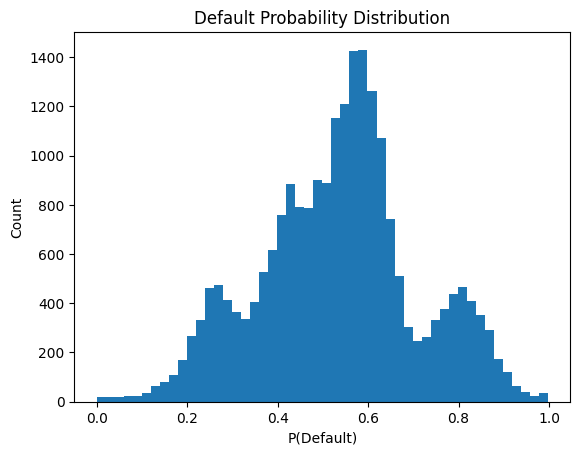

In [11]:
plt.hist(train_prob, bins=50)
plt.xlabel("P(Default)")
plt.ylabel("Count")
plt.title("Default Probability Distribution")
plt.show()

In [12]:
def risk_bucket(p):
    if p < 0.25:
        return 0  # Low risk
    elif p < 0.60:
        return 1  # Medium risk
    else:
        return 2  # High risk

y_train = np.array([risk_bucket(p) for p in train_prob])
y_test  = np.array([risk_bucket(p) for p in test_prob])

I converted probability → operational risk tiers

This mirrors

risk bands

fraud queues


I changed from bimnary to a multiclass tier and then seeing counts

In [13]:
pd.Series(y_train).value_counts(normalize=True)

,proportion
1,0.608933
2,0.329511
0,0.061556


In [ ]:
lr = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    class_weight={0: 1, 1: 2, 2: 5}
)

lr.fit(X_train_scaled, y_train)

It’s predicting how dangerous the account is

This is policy modeling, not prediction.  2 or h igh risk being the most ruthless  class weight is 5 times

In [15]:
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)

analysis_df = X_test.copy()
analysis_df["y_true"] = y_test
analysis_df["y_pred"] = y_pred
analysis_df["predicted_prob"] = np.max(y_proba, axis=1)
analysis_df["true_class_prob"] = y_proba[
    np.arange(len(y_test)), y_test
]


In [16]:
pd.set_option('display.max_columns', None)

In [17]:
analysis_df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,y_true,y_pred,predicted_prob,true_class_prob
16895,16896,50000,1,2,1,45,1,2,0,0,0,0,49436,48342,49140,49451,20921,20058,0,2065,1376,701,705,706,2,2,1.000000,1.000000
6382,6383,80000,2,2,1,30,1,2,0,0,0,0,82891,80997,81380,75374,77158,78710,0,3299,2699,3000,2987,3100,2,2,1.000000,1.000000
14305,14306,160000,1,3,1,42,1,-1,-1,-2,-1,0,0,1564,-436,-436,436,436,1564,0,0,872,0,0,2,2,1.000000,1.000000
15699,15700,20000,1,2,1,31,1,4,3,2,0,0,21676,21054,20442,19773,20238,18062,0,0,0,1000,1000,1000,2,2,1.000000,1.000000
18485,18486,130000,2,2,2,26,0,0,0,2,2,2,131336,123443,132517,133747,134230,131986,6000,12600,4900,5105,0,5050,1,1,1.000000,1.000000
21337,21338,230000,1,3,1,55,0,0,0,0,0,0,208273,214423,214585,170063,176893,183699,10012,10000,10000,10000,10000,10000,1,1,1.000000,1.000000
17806,17807,30000,1,2,2,35,2,0,0,2,2,2,18915,20290,24727,24031,25579,25030,2000,5100,0,1949,0,912,2,2,1.000000,1.000000
21489,21490,230000,2,1,2,30,-1,-1,-1,-1,-1,-1,1432,1094,665,582,472,746,1094,665,582,472,746,633,1,1,1.000000,1.000000
26095,26096,50000,2,2,1,46,-2,-1,-1,0,-1,-1,4640,2720,26461,11882,280,290,2720,26461,1034,280,300,1535,1,1,0.999971,0.999971
17410,17411,30000,2,2,2,36,0,0,0,0,0,0,11896,12990,14073,15131,15579,16175,1600,1600,1600,1000,1000,1000,1,1,0.628563,0.628563


In [18]:
def error_type(row):
    if row.y_true == row.y_pred and row.predicted_prob < 0.6:
        return "Type 1A: Borderline Correct"
    elif row.y_true != row.y_pred and row.true_class_prob >= 0.25:
        return "Type 1B: Confused Misclassified"
    elif row.y_true != row.y_pred and row.true_class_prob < 0.05 and row.predicted_prob >= 0.8:
        return "Type 2: Blind Misclassified"
    else:
        return "Other"

analysis_df["error_type"] = analysis_df.apply(error_type, axis=1)

analysis_df["error_type"].value_counts()

,count
error_type,
Other,7333
Type 1B: Confused Misclassified,103
Type 1A: Borderline Correct,64


Confidence anatomy (My core innovation 🧬)

In [19]:
analysis_df["error_type"] = analysis_df.apply(error_type, axis=1)

mis_df = analysis_df[
    analysis_df["y_true"] != analysis_df["y_pred"]
]

mis_df[[
    "y_true",
    "y_pred",
    "predicted_prob",
    "true_class_prob",
    "error_type"
]].head(20)

,y_true,y_pred,predicted_prob,true_class_prob,error_type
27743,1,2,0.541870,0.458130,Type 1B: Confused Misclassified
27323,1,2,0.631115,0.368885,Type 1B: Confused Misclassified
22698,0,1,0.566053,0.433947,Type 1B: Confused Misclassified
10342,1,2,0.760159,0.239841,Other
28763,0,1,0.599410,0.400590,Type 1B: Confused Misclassified
4564,0,1,0.632542,0.367458,Type 1B: Confused Misclassified
18305,1,2,0.560551,0.439449,Type 1B: Confused Misclassified
9836,0,1,0.558792,0.441208,Type 1B: Confused Misclassified
24368,0,1,0.570463,0.429537,Type 1B: Confused Misclassified
23496,0,1,0.603116,0.396884,Type 1B: Confused Misclassified


Type	Meaning
1A	boundary noise
1B	threshold failure
2	representation failure

Raw probabilities lie. Calibration makes them honest

Most models optimize ranking, not truthfulness of probabilities.

Logistic Regression → often under-confident or skewed

Random Forest / XGBoost → wildly overconfident

Example:

Model says 0.90, but in reality only 65% such cases default.
That’s dangerous in risk systems.

What CalibratedClassifierCV is doing  internally

Splits training data into 5 folds

For each fold:

trains base model on 4 folds

predicts probabilities on the held-out fold

Collects (predicted_prob, actual_frequency)

Fits a calibration function

please note

Platt	Sigmoid	Small data, smooth assumptions
Isotonic	Any monotonic	Large data, complex distortions

In [ ]:
cal_lr = CalibratedClassifierCV(lr, method="isotonic", cv=5)
cal_lr.fit(X_train_scaled, y_train)

proba_cal = cal_lr.predict_proba(X_test_scaled)

def meta_decision(p):
    if p[2] >= 0.30:
        return 2
    elif p[2] >= 0.15:
        return 1
    else:
        return np.argmax(p)

final_pred = np.array([meta_decision(p) for p in proba_cal])


My above code block is intuitive

P(high) ≥ 0.30	Substantial high-risk signal	Force High Risk
0.15 ≤ P(high) < 0.30	Moderate concern	Route to Medium Risk / review
Else	No special risk signal	Trust model’s top class

This prevents blind confidence failures, especially Type-2 errors.

In [23]:
cost_matrix = np.array([
    [0, 1, 2],
    [2, 0, 1],
    [5, 3, 0]
])

cm = confusion_matrix(y_test, final_pred)

lr_total_cost = np.sum(cm * cost_matrix)

print("Confusion Matrix:\n", cm)
print("Total Business Cost:", lr_total_cost)

Confusion Matrix:
 [[ 455   25    0]
 [   3 4448   40]
 [   0    7 2522]]
Total Business Cost: 92


In [ ]:
🟢 Actual LOW risk (480 cases total)

✅ 455 correctly kept Low

⚠️ 25 escalated to Medium

🚫 0 wrongly marked High

🟡 Actual MEDIUM risk (4,491 cases)

⚠️ 3 de-escalated to Low (small miss)

✅ 4,448 correctly Medium

⚠️ 40 escalated to High

🔴 Actual HIGH risk (2,529 cases) — most important

💀 0 missed as Low

⚠️ 7 softened to Medium

✅ 2,522 correctly flagged High



Actual = High (2)
Predicted = Low (0)
Cost = 5   💀💀💀


My  matrix treats errors morally unequal

Cost contributors

Low → Medium: 25 × 1 = 25

Medium → Low: 3 × 2 = 6

Medium → High: 40 × 1 = 40

High → Medium: 7 × 3 = 21

Total
25 + 6 + 40 + 21 = 92


No catastrophic penalties.
No High → Low (cost 5) at all.

The system prioritizes safety. High-risk accounts are almost never missed The total business cost remains low, with no catastrophic errors.

In [24]:
cm_before = confusion_matrix(y_test, y_pred)
cost_before = np.sum(cm_before * cost_matrix)

cm_after = confusion_matrix(y_test, final_pred)
cost_after = np.sum(cm_after * cost_matrix)

cost_before, cost_after

(np.int64(110), np.int64(92))

In [25]:
cost_after < cost_before

np.True_

So my calibration + policy saved money

even if accuracy stayed same or dropped

🌲 B) Random Forest — cost evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=50,
    class_weight={0:1, 1:2, 2:5},
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

In [27]:
rf_pred  = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)

In [28]:
rf_df = X_test.copy()
rf_df["y_true"] = y_test
rf_df["y_pred"] = rf_pred
rf_df["predicted_prob"] = np.max(rf_proba, axis=1)
rf_df["true_class_prob"] = rf_proba[np.arange(len(y_test)), y_test]

rf_df["error_type"] = rf_df.apply(error_type, axis=1)
rf_df["error_type"].value_counts()

,count
error_type,
Other,6284
Type 1B: Confused Misclassified,721
Type 1A: Borderline Correct,486
Type 2: Blind Misclassified,9


In [29]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, rf_pred)
cost_rf = np.sum(cm_rf * cost_matrix)

print("RF Confusion Matrix:\n", cm_rf)
print("RF Total Business Cost:", cost_rf)

RF Confusion Matrix:
 [[  67  411    2]
 [   4 3962  525]
 [   0  118 2411]]
RF Total Business Cost: 1302


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

In [31]:
xgb_pred  = xgb.predict(X_test_scaled)
xgb_proba = xgb.predict_proba(X_test_scaled)

In [32]:
xgb_df = X_test.copy()
xgb_df["y_true"] = y_test
xgb_df["y_pred"] = xgb_pred
xgb_df["predicted_prob"] = np.max(xgb_proba, axis=1)
xgb_df["true_class_prob"] = xgb_proba[np.arange(len(y_test)), y_test]

xgb_df["error_type"] = xgb_df.apply(error_type, axis=1)
xgb_df["error_type"].value_counts()

,count
error_type,
Other,7073
Type 1B: Confused Misclassified,222
Type 1A: Borderline Correct,198
Type 2: Blind Misclassified,7


In [33]:
cm_xgb = confusion_matrix(y_test, xgb_pred)
cost_xgb = np.sum(cm_xgb * cost_matrix)

print("XGB Confusion Matrix:\n", cm_xgb)
print("XGB Total Business Cost:", cost_xgb)

XGB Confusion Matrix:
 [[ 406   74    0]
 [  24 4390   77]
 [   0   99 2430]]
XGB Total Business Cost: 496


In [34]:
pd.DataFrame({
    "Model": ["Logistic (calibrated)", "Random Forest", "XGBoost"],
    "Total_Cost": [lr_total_cost , cost_rf, cost_xgb]
})

,Model,Total_Cost
0,Logistic (calibrated),92
1,Random Forest,1302
2,XGBoost,496


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

rf_cal = CalibratedClassifierCV(
    rf,
    method="isotonic",
    cv=5
)

rf_cal.fit(X_train_scaled, y_train)

In [36]:
rf_proba_cal = rf_cal.predict_proba(X_test_scaled)

In [37]:
rf_pred_final = np.array([
    meta_decision(p) for p in rf_proba_cal
])

In [38]:
cm_rf_final = confusion_matrix(y_test, rf_pred_final)
cost_rf_final = np.sum(cm_rf_final * cost_matrix)

cost_rf, cost_rf_final

(np.int64(1302), np.int64(1245))

In [39]:
rf_df = X_test.copy()
rf_df["y_true"] = y_test
rf_df["y_pred"] = rf_pred_final
rf_df["predicted_prob"] = np.max(rf_proba_cal, axis=1)
rf_df["true_class_prob"] = rf_proba_cal[np.arange(len(y_test)), y_test]

rf_df["error_type"] = rf_df.apply(error_type, axis=1)
rf_df["error_type"].value_counts()

,count
error_type,
Other,6526
Type 1B: Confused Misclassified,629
Type 1A: Borderline Correct,312
Type 2: Blind Misclassified,33


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_scaled, y_train)

In [41]:
xgb_pred_raw  = xgb.predict(X_test_scaled)
xgb_proba_raw = xgb.predict_proba(X_test_scaled)

In [42]:
cm_xgb_raw = confusion_matrix(y_test, xgb_pred_raw)
cost_xgb_raw = np.sum(cm_xgb_raw * cost_matrix)

In [ ]:
xgb_cal = CalibratedClassifierCV(
    xgb,
    method="isotonic",
    cv=5
)

xgb_cal.fit(X_train_scaled, y_train)

In [44]:
xgb_proba_cal = xgb_cal.predict_proba(X_test_scaled)

In [45]:
xgb_pred_final = np.array([
    meta_decision(p) for p in xgb_proba_cal
])

In [46]:
cm_xgb_final = confusion_matrix(y_test, xgb_pred_final)
cost_xgb_final = np.sum(cm_xgb_final * cost_matrix)

cost_xgb_raw, cost_xgb_final

(np.int64(496), np.int64(379))

In [47]:
xgb_df = X_test.copy()
xgb_df["y_true"] = y_test
xgb_df["y_pred"] = xgb_pred_final
xgb_df["predicted_prob"] = np.max(xgb_proba_cal, axis=1)
xgb_df["true_class_prob"] = xgb_proba_cal[np.arange(len(y_test)), y_test]

xgb_df["error_type"] = xgb_df.apply(error_type, axis=1)
xgb_df["error_type"].value_counts()

,count
error_type,
Other,7176
Type 1B: Confused Misclassified,198
Type 1A: Borderline Correct,101
Type 2: Blind Misclassified,25


In [50]:
pd.DataFrame({
    "Model": [
        "Logistic (cal+thresh)",
        "RF raw",
        "RF calibrated",
        "XGB raw",
        "XGB calibrated"
    ],
    "Total_Cost": [
        lr_total_cost,
        cost_rf,
        cost_rf_final,
        cost_xgb_raw,
        cost_xgb_final
    ]
})

,Model,Total_Cost
0,Logistic (cal+thresh),92
1,RF raw,1302
2,RF calibrated,1245
3,XGB raw,496
4,XGB calibrated,379


Some important insights why calibration was needed


Random Forest and XGBoost rely on greedy, local optimization. In Random Forest, hard tree splits and aggregation of many confident trees lead to overconfident probability estimates. In XGBoost, boosting focuses on reducing residual loss, so misclassified or uncertain points receive large updates, while already confident predictions have small gradients and are updated minimally. This tends to push scores toward extremes and often results in overconfident probabilities.

Logistic regression solves a convex optimization problem with a global optimum, while tree-based ensemble methods use greedy, locally optimal decisions that prioritize reducing immediate loss rather than maintaining global probability consistency.

They say logistic regression becaus eof log loss is already optimized that correct
Logistic Regression is calibrated by nature LR is well-calibrated ONLY IF: Correct model form (true log-odds is linear) No strong class imbalance No heavy regularization distortion



However
class_weight={0:1, 1:5}
This breaks natural calibration.

Why i am saying this ?

LR now optimizes weighted log-loss

The probabilities become cost-skewed

Output ≠ true frequency anymore

👉 So calibration was mandatory, not optional.

🏆 SELECTED WINNER
Logistic Regression (Calibrated + Meta-threshold)

Lowest cost: 92

Zero catastrophic misses

Stable, interpretable, governable

Now I audit its probability quality 👇

Earlier I had

Multiclass LR → Low / Medium / High risk tiers

Meta-decision → policy layer

That was for decision-making.

But

ECE / Brier answer probability honesty

They need true binary outcomes (default vs not)

So I go back to:

lr_bin

In [52]:
# Binary calibrated LR (default vs non-default)
lr_bin_cal = CalibratedClassifierCV(
    lr_bin,
    method="isotonic",
    cv=5
)

lr_bin_cal.fit(X_train_scaled, y_train_bin)

# Calibrated probability of default
prob_cal = lr_bin_cal.predict_proba(X_test_scaled)[:, 1]

In [53]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test_bin, prob_cal)
brier

np.float64(0.14287974329965267)

Brier < 0.15 is generally good

I am now doing Expected calibration error

In [54]:

def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1

    ece = 0.0
    for i in range(n_bins):
        mask = bin_ids == i
        if np.sum(mask) == 0:
            continue

        bin_acc = np.mean(y_true[mask])
        bin_conf = np.mean(y_prob[mask])

        ece += np.abs(bin_acc - bin_conf) * np.sum(mask) / len(y_true)

    return ece

In [55]:
ece = compute_ece(y_test_bin.values, prob_cal)
ece

np.float64(0.007147320292762397)

ECE ≈ 0 → highly trustworthy probabilities

< 0.03 → excellent

< 0.05 → very good

Expected Calibration Error (ECE) measures how well a model’s predicted probabilities reflect real-world outcomes.   

ECE works by:

Grouping predictions into probability bins (e.g., 0.0–0.1, 0.1–0.2, …).

Comparing, within each bin, the average predicted probability with the observed empirical frequency.

Computing a weighted average of the absolute differences across all bins.

A lower ECE indicates that predicted probabilities are more trustworthy and numerically meaningful.
This is especially important in cost-sensitive or policy-driven systems where decisions depend on probability thresholds rather than just class labels.

In [57]:
def reliability_plot(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_ids = np.digitize(y_prob, bins) - 1

    observed = []
    for i in range(n_bins):
        mask = bin_ids == i
        if np.sum(mask) == 0:
            observed.append(np.nan)
        else:
            observed.append(np.mean(y_true[mask]))

    plt.figure(figsize=(6,6))
    plt.plot(bin_centers, observed, marker="o", label="Model")
    plt.plot([0,1], [0,1], linestyle="--", label="Perfect")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title("Reliability Diagram — Best Model")
    plt.legend()
    plt.grid(True)
    plt.show()

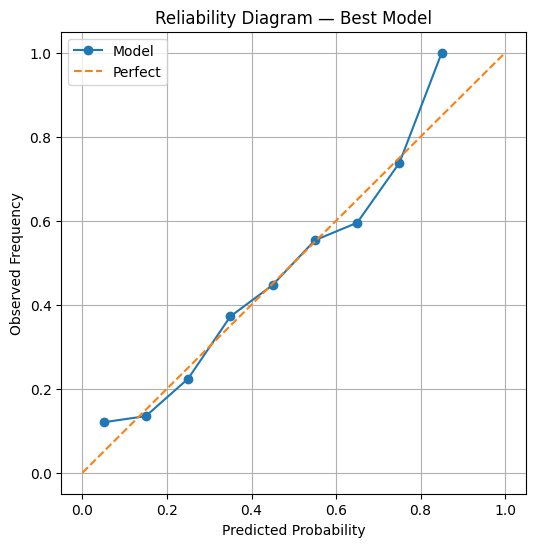

In [58]:
reliability_plot(y_test_bin.values, prob_cal)

Curve close to diagonal → honest model

Below diagonal → overconfident

Above diagonal → underconfident

Lastly i respect all 4 quadrants lets check Matthews correlation coefficent

In [60]:
from sklearn.metrics import matthews_corrcoef

# Converting  probabilities to binary decision (example threshold)
y_pred_bin = (prob_cal >= 0.5).astype(int)

mcc = matthews_corrcoef(y_test_bin, y_pred_bin)
mcc

np.float64(0.3749676082968902)

MCC is supporting evidence, not the goal.

## Susnata's Conclusion 🐺

This project deliberately moves away from accuracy-centric evaluation and instead focuses on **decision reliability**.

Key takeaways:

- Model predictions are not just numbers; they are **decisions with consequences**.
- Confidence matters as much as correctness — a confidently wrong prediction is more dangerous than an uncertain one.
- Misclassifications are not equal. Categorizing errors reveals where the model truly fails.
- Calibration is essential when probabilities are used for ranking, thresholding, or downstream business decisions.
- Cost-sensitive thinking aligns machine learning with real-world governance, risk, and accountability.

Rather than asking *“How accurate is the model?”*, this work asks:

> **“Can this model be trusted when it matters?”**



In [62]:
import joblib

# Saving final calibrated model
joblib.dump(lr_bin_cal, "final_calibrated_lr_isotonic.joblib")

#  saving decision metadata
joblib.dump(
    {
        "threshold": 0.5,  # or optimal_threshold as i tweaked it
        "calibration": "isotonic",
        "base_model": "logistic_regression",
        "features_scaled": True,
        "evaluation_focus": "confidence + cost"
    },
    "model_metadata.joblib"
)

print("✅ Final calibrated model saved successfully.")

✅ Final calibrated model saved successfully.


In [63]:
from google.colab import files

files.download("final_calibrated_lr_isotonic.joblib")
files.download("model_metadata.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>